Group 48

Pavel Detvan, Urszula Sawczuk, Elias Miguel Leal Spohr Gija Gonzalez 

i6306211, i6306409, i6314878

**Use of genAI tools (e.g. chatGPT), websites (e.g. stackoverflow)**: *list websites where you found code (or other info) as well as include information on how you used genAI tools*

# Data Analysis, Clinic 3

By completing and delivering the clinic tasks you will know how to :

1. Run Classification Models (Logistic Regression, Decision Trees, Random Forests, etc.) in Python
1. Explain and tackle issues like missing values or class inbalance in your dataset
1. Judge the results of a classification model using AUROC scores
1. Select a proper algorithm that works well with your data using techniques like:
    * Cross Validation
    * Regularization
    
---
### Important Dates

- Clinic release: Tue, 18th Feb
- **Clinic due**: Fri, 28th Feb late night (wildcards possible, apply to the group)
---
##  Some rules

* For this clinic, like the previous one, we are asking you to use specific libraries that are included in the `requirements.txt`. If you use any additional library, this may complicate the grading process, and we reserve the right to penalize your grade for unnecessary complexity of the solution. All the questions can be solved with the libraries in `requirements.txt`.

* Make sure that you include a proper amount/mix of comments, results and code. More specifically, be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice. To avoid confusion: use short comments for longer code answers.

* Back up any hypotheses and claims with data, since this is an important aspect of the course.

* Please write all your comments in English, and use meaningful variable names (as possible) in your code. 

* In the end, make sure that all cells are executed properly and everything you need to show is in your (execucted) notebook. We will not run your notebook for you! 

- In continuation to the previous point, interactive plots, such as those generated using the ‘plotly’ package, should be strictly avoided! Make sure to print results and/or dataframes that confirm you have properly addressed the task.

* You are asked to deliver **only your executed notebook file, .ipnyb** and nothing else. If you deliver other files, we will not grade anything.

* Honor code applies to these tasks. If you are not certain about an action, consult with Jerry.

**A Note from Jerry on using Language Models (LMs)**

If you try hard enough, you will likely get away with cheating (that does not only apply to LMs). Fortunately, my job is not to police, but rather to educate you. So, please consider the following:

I assume that you are taking this course to learn something! LMs are not always right ([they often fail in silly ways](https://community.openai.com/t/why-9-11-is-larger-than-9-9-incredible/869824/4)). This course should prepare you to detect when they are wrong!

I don't restrict the use of LMs because I see the value of being helped when coding (esp. in the context of pandas dataframes nightmare :)). Based on what we saw last year in your notebooks, it's pretty clear when you "copy" some code and then you struggle to interpret the results. This is the essence of this course and of the skills you should try build for yourself: Many people can run fancy models these days but not many people can interpret the results correctly. Try to be the latter ones.


# Context

In this clinic, we will continue navigating the amazing world of modeling and explore classification models under extreme inbalance and missing values scenarios.

The first part of the assignment (Questions 1-9) will help you understand the impact of inbalance and missingness in the classification performance and explore different scenarios on how to improve. Most steps are laid out for you, but you are welcome to deviate.

The second part of the assignment (Question 10) is purposefully left open-ended (as in the previous clinics). In this case, you will be allowed to compare different classifiers of your choice in an effort to deal with the imbalance in the data. You can also implement some of the techniques we discussed in class about imbalances. 

## Score breakdown

Question | Points
--- | ---
[Question 1](#q1) | 3
[Question 2](#q2) | 3
[Question 3](#q3) | 4
[Question 4](#q4) | 4
[Question 5](#q5) | 4
[Question 6](#q6) | 6
[Question 7](#q7) | 4
[Question 8](#q8) | 8
[Question 9](#q9) | 4
[Question 10](#q10)| 15 
Total | 55

This score will be scaled down to 1 and that will be your final clinic score.

In [ ]:
#feel free to include additional libraries, as long as they are included in the requirements.txt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
%matplotlib inline
import seaborn as sns
sns.set(context='paper')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

## Part 1: Determine the Inbalance (Asymmetry)

First, we would like to notice in our data that they are highly unbalanced (assymetric). Load the data which should contain 9 columns (`health`, `age`, `sex`, `educ`, `sexornt`, `partyid`, `race`, `married`, `income`). `Age`, `educ` (how many years of education a person has) and `income` are quantitative, the others are qualitative.

In [2]:
gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

,health,age,sex,educ,sexornt,partyid,race,married,income
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN


Our goal is to predict if a person is in poor health or not. Let's create some dummy variables in order to measure that.


In [3]:
poorhealth = np.where(gssdata['health'] == 'poor',1,0)
notpoorhealth = np.where(gssdata['health'] != 'poor',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['notpoorhealth'] = notpoorhealth


In [4]:
gssdata.describe()

,age,educ,married,income,poorhealth,notpoorhealth
count,1551.000000,1551.000000,1551.000000,963.000000,1551.000000,1551.000000
mean,48.172792,13.803353,0.732431,15633.177570,0.063830,0.936170
std,17.051151,3.011700,0.442835,5064.191118,0.244528,0.244528
min,18.000000,0.000000,0.000000,500.000000,0.000000,0.000000
25%,33.500000,12.000000,0.000000,13750.000000,0.000000,1.000000
50%,48.000000,14.000000,1.000000,18750.000000,0.000000,1.000000
75%,61.000000,16.000000,1.000000,18750.000000,0.000000,1.000000
max,89.000000,20.000000,1.000000,18750.000000,1.000000,1.000000


### Question 1 <a name="q1"></a>

a) Can you quantify what is the degree of inbalance? Mention a percentage of the split between the positive and the negative class.<br>
b) What is the majority and the minority class?<br>
c) What would be the accuracy of a classifier that predicts everybody NOT being in poor health?<br>
d) Discuss (with each other and the teachers) why accuracy is not a good metric.<br>

**Your answer goes here**

a) Looking at the descriptive statics of the data we cna quickly see the imbalance in our dataset. When we look at the mean we see 0.06383 (approximately 6.38%). This means that only 6.38% percent of the samples are labelled are 'poorhealth', while 93.62% are labelled 'notpoorhealth'. So we roughly have a 1:15 ratio (poorhealth:notpoorhealth), which could cause issues wiht model training, wiht bias towards thew majority class.<br>
b) The majority class is 'notpoorhealth' and the minority is 'poorhealth'.<br>
c) The accuracy of such classifier would be about 93.62% as this is the amount of people in 'notpoorhealth'. This shows why accuracy alone is a poor metric with imbalanced classes.<br>
d) The accuracy is not a good metric cause despite it being high, in the case of classyfing everyone as 'notpoorhealth', it is actually lying to us. We have missed all of the cases of 'poorhealth' which defeats the whole purpose of classification. Accuracy treats all errors equally, which doesn't show the impact of mistakes. We should take a look at the False Negatives and False Positives to agin better insight. It is also sensitive to changes in dataset distributin. If the number of poeple in 'poorhealth' increases, our accuracy would change even if our model's discriminitive power stays the same. Instead of using only accuracy we should focus on F1-score or ROC-AUC.


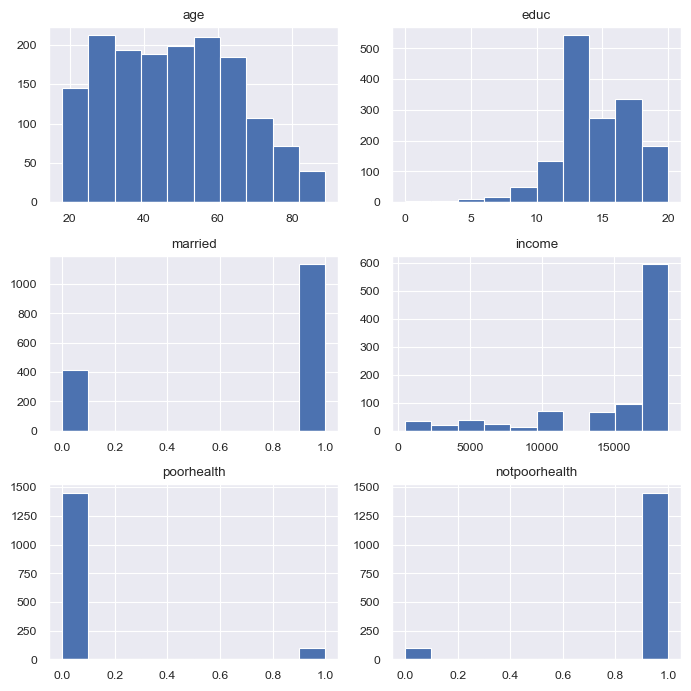

In [5]:
####HERE YOU CAN ADD CODE AND MORE COMMENTS

gssdata.hist(figsize=(7,7))
plt.tight_layout()



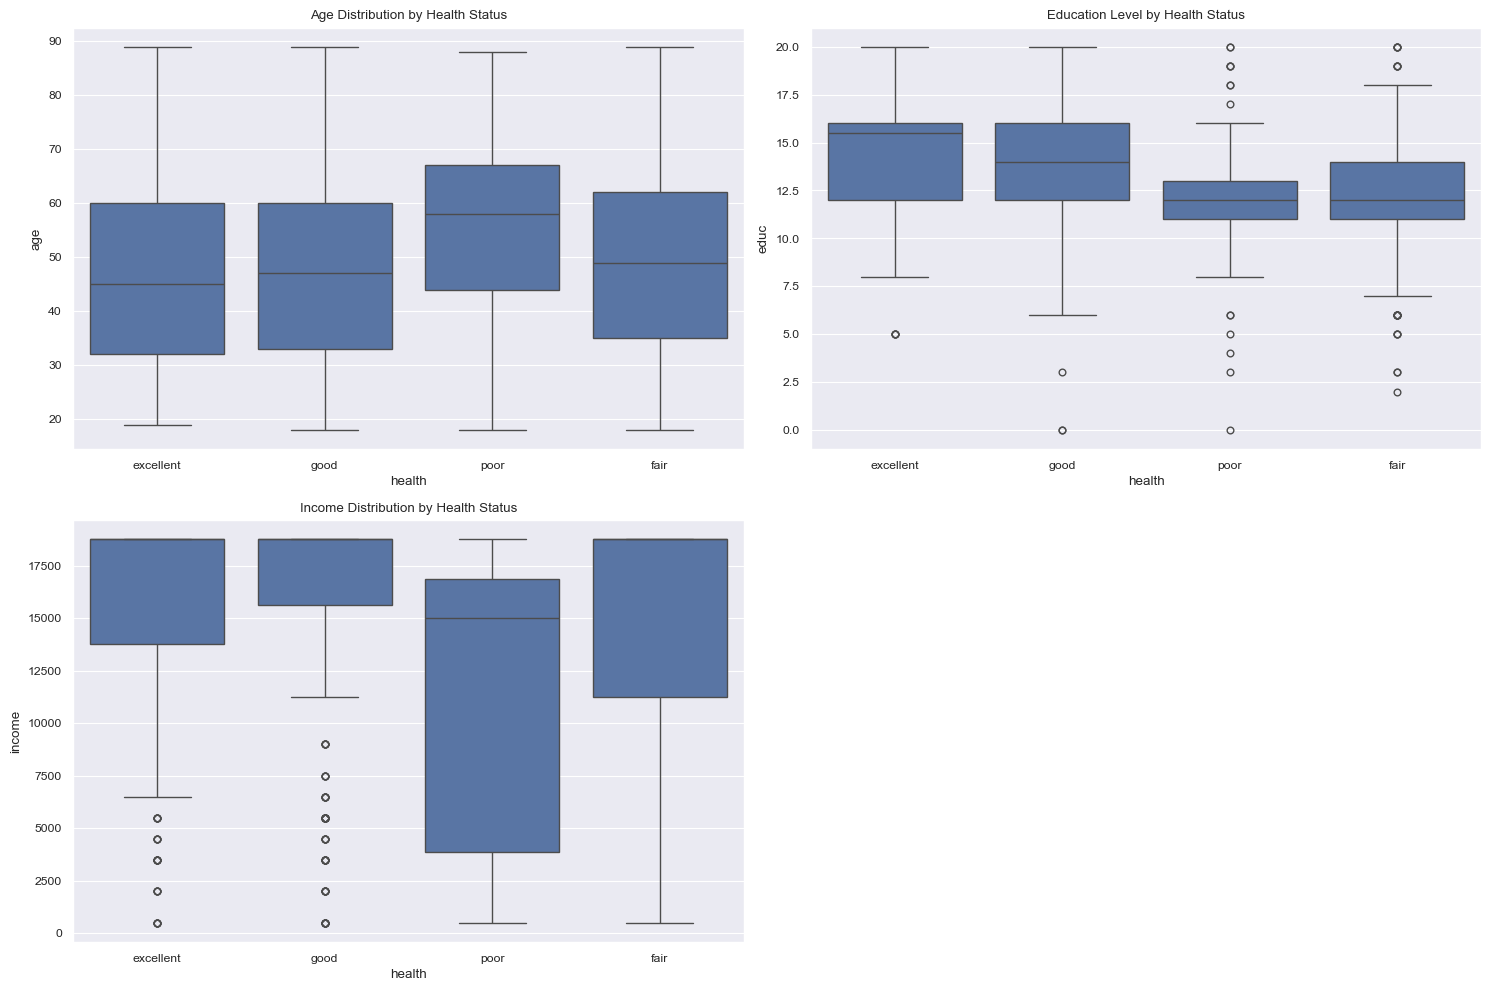

In [6]:
plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 1)
sns.boxplot(x='health', y='age', data=gssdata)
plt.title('Age Distribution by Health Status')

plt.subplot(2, 2, 2)
sns.boxplot(x='health', y='educ', data=gssdata)
plt.title('Education Level by Health Status')

plt.subplot(2, 2, 3)
sns.boxplot(x='health', y='income', data=gssdata)
plt.title('Income Distribution by Health Status')

plt.tight_layout()

## Part 2: Fit a logistic model ignoring missing values

Let's begin by fitting a logistic regression model to predict poor health based on several of the other predictors in the model. In part 3, you will be asked to regularize (with cross-validation) to make sure you do not overfit, but for this part, we will keep things simple.

First, we need to do a small amount of data clean-up (ignoring missingness for now in `income`). Best practice would be to split into train/test first before looking at the data, but again, we can keep it simple in this part.

If you ignore the missingness `sklearn` might crash (`ValueError: Input contains NaN, infinity or a value too large for dtype('float64')`.) So you can also consider not using that variable in the model

In [7]:
#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] ==  'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
gssdata = gssdata.join(dummy_vars)

In [8]:
#Let's get a sense of the data we have
print(gssdata.shape)
gssdata.head()
#print(gssdata.columns)

(1551, 22)


,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,False,True,False,False,True
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,False,True,False,False,True
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,...,False,False,True,False,False,False,True,False,False,True
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,...,False,False,True,False,False,True,False,False,False,True
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,...,False,False,True,False,False,True,False,False,False,True


### Question 2 <a name="q2"></a>

In the code below try to fit your logistic regression model and provide some short comments on the performance of the model. You don't need to be detailed (yet), but make sure to make 1-2 observations at least.

In [9]:
######HERE YOUR CODE TO FIT THE MODEL
######
######
######Look up LogisticRegression() from scikitlearn

features = ['age', 'female', 'educ', 'married', 
           'sexornt_bisexual', 'sexornt_dont know', 'sexornt_heterosexual or straight',
           'sexornt_homosexual or gay', 'partyid_dem', 'partyid_other', 'partyid_rep', 'race_black', 'race_other', 'race_white']

X = gssdata[features]
y = gssdata['poorhealth']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Training Accuracy: 0.941
Test Accuracy: 0.920
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Confusion Matrix:
[[286   0]
 [ 25   0]]


c:\Users\Pavel Detvan\anaconda3\envs\cuda_test\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Your answer goes here**

---
We got a training accuracy of approximately 94.1% and a test accuracy of approxiamtely 92%, but our precision, recall and F1-score are all 0:(((. Also we can see that we have 286 True Negatives and 25 False Negatives. So we know exactly what has happened. Our model classified everything as the negative class, being biased towards it as it had way more instances present the the positive class. We see why accuracy alone is not a good metric and can be misleading.

## 2a: Handling missingness approach \#1: remove observations. 

We do not know how sklearn will treat the missing values (the `NaN`s), so we should do handle them ourselves.  As a base case, let's remove all observations with missingness.

### Question 3 <a name="q3"></a>

In the code below, remove all observations that are not complete. Report on how many samples were dropped. Do a quick check to see how dropping observations affected the amount of poor health individuals. Do an appropriate plot to show this.

Initial sample size: 1551
Final sample size after dropping missing values: 963
Total dropped observations: 588
Poor health cases before cleaning: 99
Poor health cases after cleaning: 16


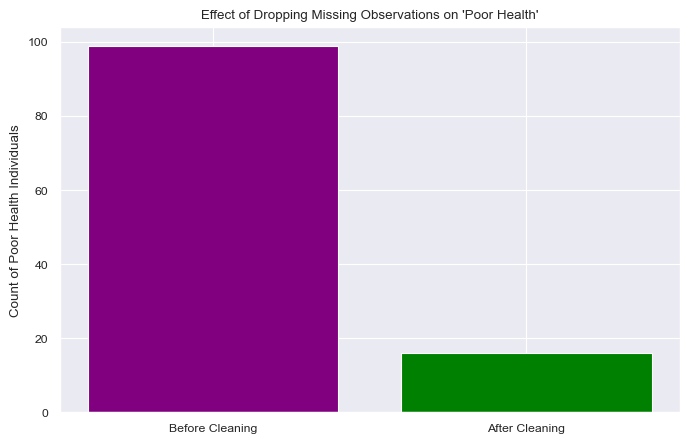

In [10]:
##In the code below: Remove all observations that are not complete
##Report on how many samples were dropped.

#Do a quick check to see how dropping observations affected the amount of poor health individuals
#Do an appropriate plot to show this (e.g. boxplot)

# gssdata_full #<---this should be your final data frame.

initial_count = len(gssdata)

gssdata_full = gssdata.dropna()

final_count = len(gssdata_full)
dropped_count = initial_count - final_count

print(f"Initial sample size: {initial_count}")
print(f"Final sample size after dropping missing values: {final_count}")
print(f"Total dropped observations: {dropped_count}")

# compare poorhelth
poorhealth_before = gssdata['poorhealth'].sum()
poorhealth_after = gssdata_full['poorhealth'].sum()

print(f"Poor health cases before cleaning: {poorhealth_before}")
print(f"Poor health cases after cleaning: {poorhealth_after}")

plt.figure(figsize=(8, 5))
plt.bar(["Before Cleaning", "After Cleaning"], [poorhealth_before, poorhealth_after], color=['purple', 'green'])
plt.ylabel("Count of Poor Health Individuals")
plt.title("Effect of Dropping Missing Observations on 'Poor Health'")
plt.show()


**Your answer goes here**

In total we removed 588 samples from the total amount when deleting the rows with NAN values. In this we have 83 'poorhealth' samples, which made them drop from 99 to 16 instances. This is almost 83% of all of them which is a lot and makes our dataset even more imbalanced with now a ratio of rouglhy 1:59 (poorhealth:notpoorhealth). We got a suspicion that most of the Nan are in column "income", so below we drop only this column and observe the results again:

Initial sample size: 1551
Final sample size after dropping missing values (after removing 'income'): 1551
Total dropped observations: 0
Poor health cases before cleaning: 99
Poor health cases after cleaning: 99


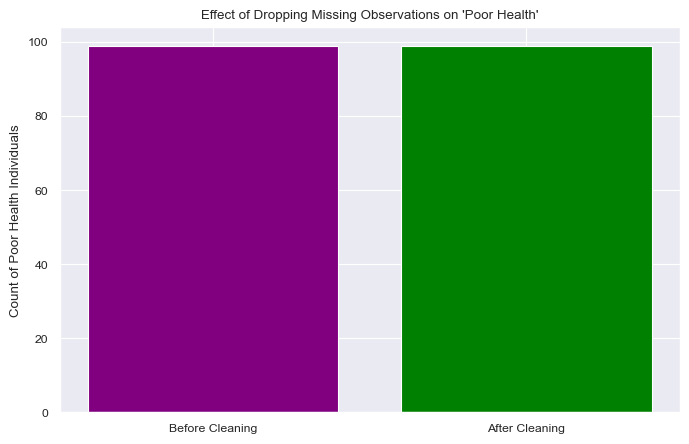

In [11]:
initial_count = len(gssdata)

# Drop the 'income' column
gssdata_clean = gssdata.drop(columns=['income'])

# Drop rows with any remaining missing values in the other columns
gssdata_full = gssdata_clean.dropna()

final_count = len(gssdata_full)
dropped_count = initial_count - final_count

print(f"Initial sample size: {initial_count}")
print(f"Final sample size after dropping missing values (after removing 'income'): {final_count}")
print(f"Total dropped observations: {dropped_count}")

# Compare poor health counts before and after cleaning
poorhealth_before = gssdata['poorhealth'].sum()
poorhealth_after = gssdata_full['poorhealth'].sum()

print(f"Poor health cases before cleaning: {poorhealth_before}")
print(f"Poor health cases after cleaning: {poorhealth_after}")

plt.figure(figsize=(8, 5))
plt.bar(["Before Cleaning", "After Cleaning"], [poorhealth_before, poorhealth_after], color=['purple', 'green'])
plt.ylabel("Count of Poor Health Individuals")
plt.title("Effect of Dropping Missing Observations on 'Poor Health'")
plt.show()

And we can see that after dropping 'income' column we are preserving all the data.

In [12]:
gssdata_full.head()

,health,age,sex,educ,sexornt,partyid,race,married,poorhealth,notpoorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,0,1,...,False,False,True,False,False,False,True,False,False,True
1,excellent,26,female,16,heterosexual or straight,rep,white,1,0,1,...,False,False,True,False,False,False,True,False,False,True
2,good,59,male,13,heterosexual or straight,rep,white,1,0,1,...,False,False,True,False,False,False,True,False,False,True
3,excellent,74,female,17,heterosexual or straight,other,white,1,0,1,...,False,False,True,False,False,True,False,False,False,True
4,poor,37,female,10,heterosexual or straight,other,white,0,1,0,...,False,False,True,False,False,True,False,False,False,True


In [13]:
#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

itrain, itest = train_test_split(range(gssdata_full.shape[0]), test_size=0.25, random_state=42)

#gsstemp = gssdata_full.drop(['health','fairhealth','goodhealth','excellenthealth','sex','sexornt','partyid','race'],axis=1)
#gsstemp = gssdata_full[['age','educ','female','partyid_dem','partyid_rep','income']]
gsstemp = gssdata_full[['age','educ','female','married','partyid_dem','partyid_rep','sexornt_bisexual','sexornt_dont know','sexornt_homosexual or gay', 'race_black', 'race_other']]

X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = gssdata_full['poorhealth'].iloc[itrain]
y_test = gssdata_full['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((1163,), (1163, 11), (388,), (388, 11))

### Question 4 <a name="q4"></a>

Fit a logistic regression mode with `C=1000000` (that means that we don't any regularization) and evaluate the classification accuracy on the test set. Discuss whether this accuracy is good/bad.

Then move below to be reminded on the confusion matrix.

In [14]:
#####################
# Your code here: fit a logistic model with C=1000000 and evaluate classification accuracy on the test set.
# Then move below to be reminded on the confusion matrix
#####################


#logit1
#<-- this should be the name of your model so as to work below with the confusion matrix 
      #(or if you have a different name, then change it there as well)

logit1 = LogisticRegression(C=1000000, random_state=42, max_iter=1000)
logit1.fit(X_train, y_train)

y_train_pred = logit1.predict(X_train)
y_test_pred = logit1.predict(X_test)

# Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Confusion Matrix:\n{conf_matrix}")

print(y_test.value_counts())

Training Accuracy: 0.942
Test Accuracy: 0.918
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Confusion Matrix:
[[356   0]
 [ 32   0]]
poorhealth
0    356
1     32
Name: count, dtype: int64


c:\Users\Pavel Detvan\anaconda3\envs\cuda_test\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Your answer goes here**

Once again the model classified everything as Negative class (all samples as not-poor-health). The accuracy is not bad, but again this metric is not representative here as we have big class imbalance. Its important to look at other metrics too, such as precision, recall and f1 score, and in here they are all 0, which is not good.

## Reminder: The Confusion Matrix & Some Useful Functions

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](./confusionmatrix_360.png)


IMPORTANT NOTE: In `sklearn`, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



In [ ]:
#the name of your model should be logit1 (to work with the code below)
print(confusion_matrix(y_test,logit1.predict(X_test)))

[[356   0]
 [ 32   0]]


The following function can be used to create confusion tables with different thresholds (same as we did in the notebook explaing AUROC)

In [16]:
###manually making confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [17]:
#Try it here!

print(confusion_matrix(y_test,t_repredict(logit1, 0.06, X_test)))
print(confusion_matrix(y_train,t_repredict(logit1, 0.06, X_train)))

[[248 108]
 [ 10  22]]
[[759 337]
 [ 24  43]]


With different thresholds the model finally predicts some positives, but also incorrectly labels some negatives as positive (False Positives). This is a classic precision-recall trade-off: we catch more actual positives but risk more false alarms.

The following fuction should create ROC curves for your models, based on the model and the ground truth. Feel free to change it and improve it!

In [18]:
#making ROC curves for this model

#name: name of your model to appear on the figure (can be arbitrary)
#clf: the model as you named it - will be used for getting the predictions (model object)
#ytest, xtest: your test data
#skip, labe: steps that control how many points you see in the ROC curve and how many labels are there

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM? (but double-check this pleaseee)
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    
    #this is the single value for the AUC score
    roc_auc = auc(fpr, tpr)
    
    if skip: 
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    
    #add labels to the curve
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

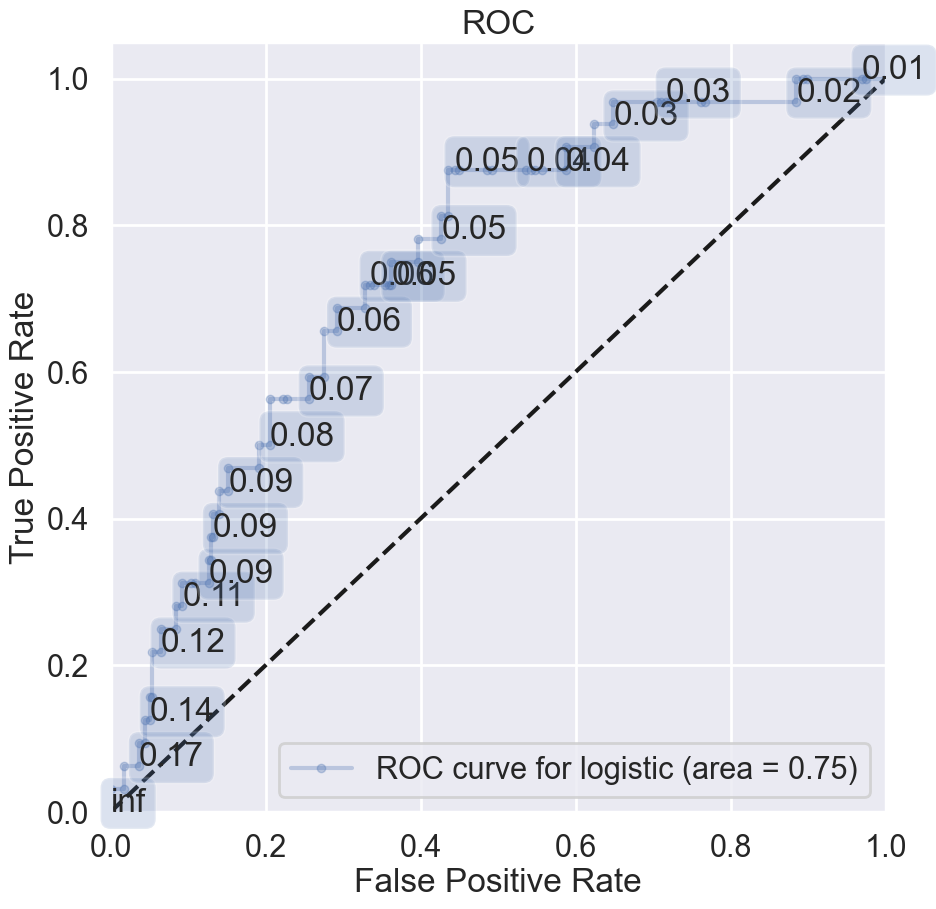

In [19]:
#This is how the above function should be used

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",logit1, y_test, X_test, labe=4, skip=0)
plt.show()

### Question 5 <a name="q5"></a>


What does the above ROC curve tell you about the quality of the model we fit on the data?

**Your answer goes here**

The ROC curve shows that the logistic regression model has some ability to distinguish between positive and negative classes, which is showed by an AUC (Area Under the Curve) of 0.75, which is better than random guessing. Lowering the threshold increases the model’s true positive rate, but it also increases the false positive rate. This means the model can capture more of the minority class, but at the risk of misclassifying additional negatives as positives. Thus, while the ROC curve indicates that the model has some discriminative power, the threshold needs to be tuned and evaluated in depth using metrics beyond accuracy, especially when there is class imbalance.

## Let's get back the data with missingness

It's time to build a model to impute the missing data!

---

## 2b: Handling missingness approach \#2: impute the mean 

### Question 6 <a name="q6"></a>

In your first approach, make a copy of the original data frame and impute the missing values by assuming that every missing value shoudl be replaced by the mean. Make sure to do a histogram as well and compare it with the original!

Then fit a model (as before in 2a.) and judge the model accuracy. Use the functions for the ROC curve to establish the result.

Imputed Income Mean: 15633.18


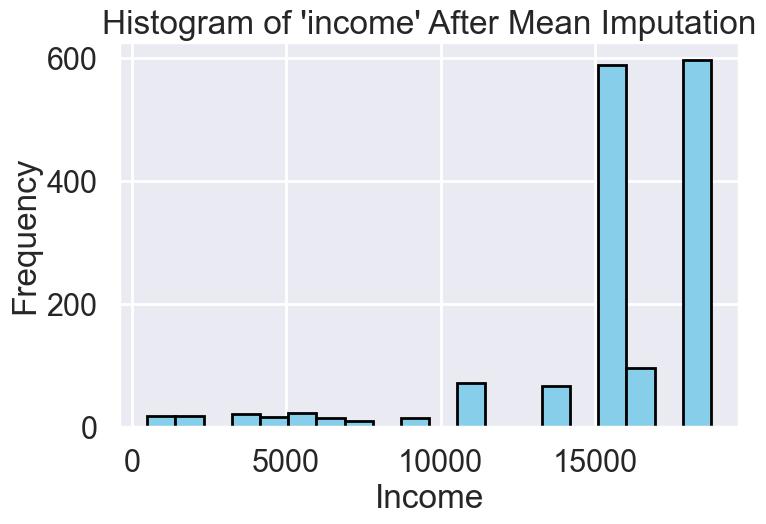

In [20]:
# Copy the original data
gssdata_imputed = gssdata.copy()

# Compute the mean of 'income' (ignoring NaNs)
income_mean = gssdata['income'].mean()

# Fill missing values in 'income' with the mean
gssdata_imputed['income'] = gssdata_imputed['income'].fillna(income_mean)

print(f"Imputed Income Mean: {income_mean:.2f}")
plt.figure(figsize=(8,5))
plt.hist(gssdata_imputed['income'], bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of 'income' After Mean Imputation")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

In [21]:
features = [
    'age', 
    'educ', 
    'female', 
    'married',
    'partyid_dem', 
    'partyid_rep',
    'sexornt_bisexual',
    'sexornt_dont know',
    'sexornt_homosexual or gay',
    'race_black',
    'race_other',
    'income'  # Keep income after imputation
]

In [22]:
itrain, itest = train_test_split(range(gssdata_imputed.shape[0]), test_size=0.25, random_state=42)

X_imputed = gssdata_imputed[features]
y_imputed = gssdata_imputed['poorhealth']

X_train_imp = X_imputed.iloc[itrain, :]
X_test_imp = X_imputed.iloc[itest, :]
y_train_imp = y_imputed.iloc[itrain]
y_test_imp = y_imputed.iloc[itest]

print("Shapes -> X_train_imp:", X_train_imp.shape, 
      "y_train_imp:", y_train_imp.shape,
      "X_test_imp:", X_test_imp.shape, 
      "y_test_imp:", y_test_imp.shape)


Shapes -> X_train_imp: (1163, 12) y_train_imp: (1163,) X_test_imp: (388, 12) y_test_imp: (388,)


In [23]:
logit2 = LogisticRegression(C=1000000, random_state=42, max_iter=1000)
logit2.fit(X_train_imp, y_train_imp)

y_pred_imp = logit2.predict(X_test_imp)
test_accuracy_imp = accuracy_score(y_test_imp, y_pred_imp)

print(f"Test set accuracy with mean-imputed 'income': {test_accuracy_imp:.3f}")

cm_default = confusion_matrix(y_test_imp, y_pred_imp)
print("Confusion Matrix (Threshold = 0.5):\n", cm_default)


Test set accuracy with mean-imputed 'income': 0.918
Confusion Matrix (Threshold = 0.5):
 [[356   0]
 [ 32   0]]


c:\Users\Pavel Detvan\anaconda3\envs\cuda_test\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
def t_repredict(est, t, xtest):
    """Predict using a custom threshold t for the positive class probability."""
    probs = est.predict_proba(xtest)
    ypred = (probs[:, 1] > t).astype(int)
    return ypred

for thresh in [0.1, 0.2, 0.3, 0.4]:
    y_pred_thresh = t_repredict(logit2, thresh, X_test_imp)
    cm = confusion_matrix(y_test_imp, y_pred_thresh)
    print(f"\nThreshold = {thresh}")
    print(cm)



Threshold = 0.1
[[311  45]
 [ 22  10]]

Threshold = 0.2
[[348   8]
 [ 31   1]]

Threshold = 0.3
[[355   1]
 [ 31   1]]

Threshold = 0.4
[[356   0]
 [ 32   0]]


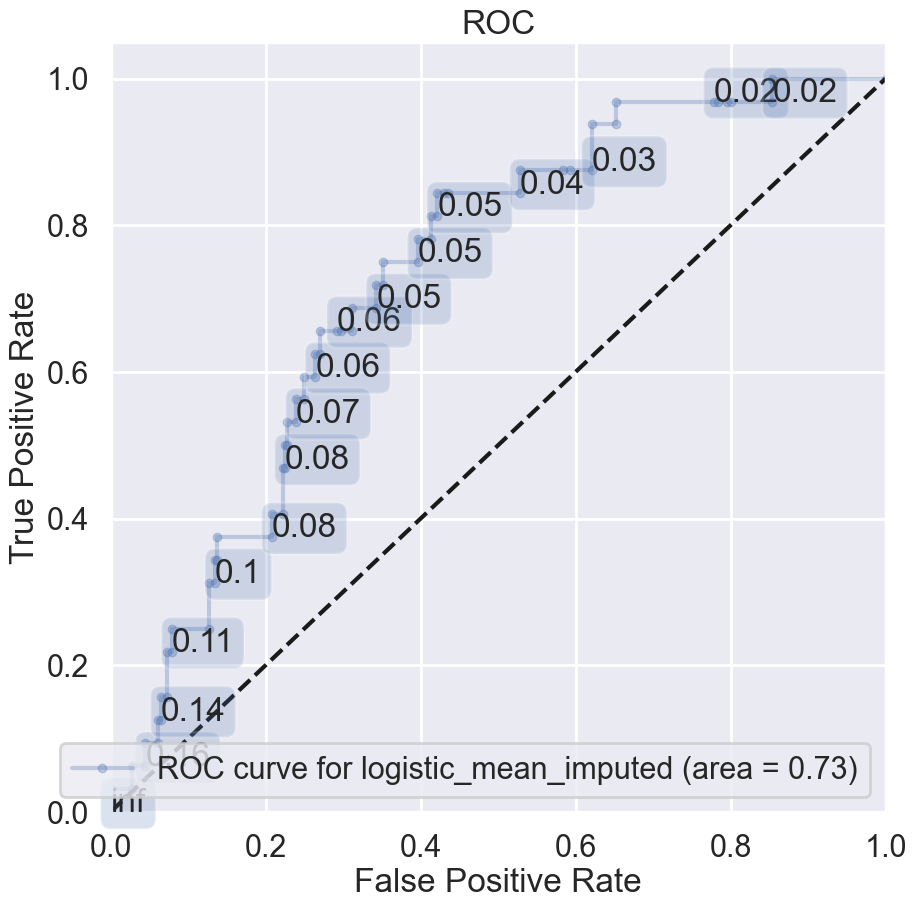

In [25]:
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(10,10))
ax = make_roc("logistic_mean_imputed", logit2, y_test_imp, X_test_imp, labe=4, skip=0)
plt.show()


### Question 7 <a name="q7"></a>


What does the above ROC curve tell you about the quality of the model we fit on the data?

**your answer goes here**

An AUC of about 0.73 indicates that our model, although better than random guessing, is not performing exceptionally well in distinguishing between individuals in poor health and those not in poor health. The model still has a tendency to miss positive cases at the default threshold.

When we compare this model’s ROC curve and AUC to the previous approach (where the income column was dropped entirely), we notice a slight decline in performance from about 0.75 to 0.73. This observation means that imputing missing income values with the mean did not enhance the model’s predictive power in this dataset. While we have expected that adding more information (in this case, income) could lead to an improvement, the imputation may have introduced noise to the data as it is not very complex or reliable.

---

## 2c: Handling missingness approach \#3: impute with a model (linear regression here)

The third and most sophisticated approach would be to fit a linear model (multiple regression) to estimate income based on the other features (`age`, `educ`, `sex`, `partyid`).

### Question 8 <a name="q8"></a>

Train this model below and then use it in order to compute the missing values. The steps should be as follows:

+ figure out which observations have missing values for income,
+ create the values you will use for imputation by:<br>
a) calculating the predicted values for the observations with missingness using the linear model<br>
b) use these values to impute back into the income variable in the missing entries<br>
+ Do a histogram to see how does that look like

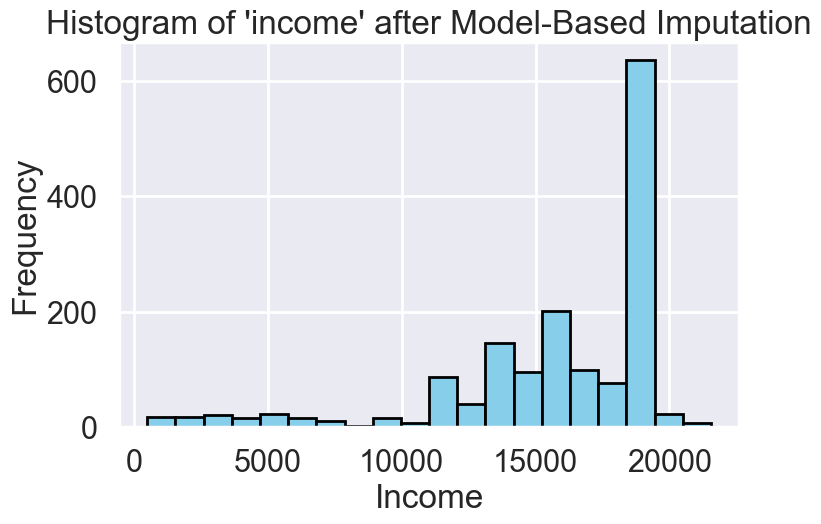

In [ ]:
gssdata_lin = gssdata.copy()
missing = gssdata_lin['income'].isnull()

# Define the features to use for imputation. We use variables that are likely related to income.
impute_features = ['age', 'educ', 'female', 'partyid_dem', 'partyid_rep', 'race_black', 'race_other']
#impute_features = ['age', 'educ', 'female', 'partyid_dem', 'partyid_rep', 'race_black', 'race_other', 'poor_health']

# Use rows where income is NOT missing as the training set for the imputation model.
train_data_impute = gssdata_lin[~missing]
X_train_impute = train_data_impute[impute_features]
y_train_impute = train_data_impute['income']

# Train the linear regression model for income prediction
lr_impute = LinearRegression()
lr_impute.fit(X_train_impute, y_train_impute)

X_missing = gssdata_lin.loc[missing, impute_features]
if not X_missing.empty:
    predicted_income = lr_impute.predict(X_missing)
    gssdata_lin.loc[missing, 'income'] = predicted_income

plt.figure(figsize=(8,5))
plt.hist(gssdata_lin['income'], bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of 'income' after Model-Based Imputation")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

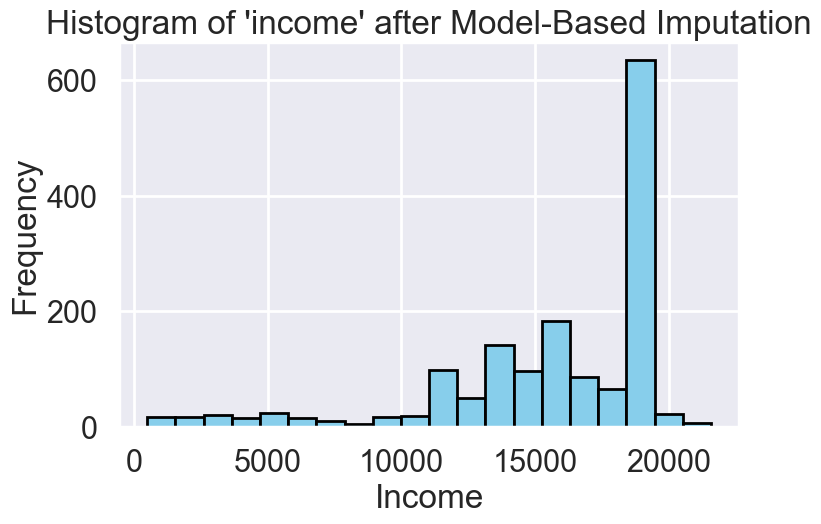

In [ ]:
gssdata_lin = gssdata.copy()
missing = gssdata_lin['income'].isnull()

# Define the features to use for imputation. We use variables that are likely related to income.
#impute_features = ['age', 'educ', 'female', 'partyid_dem', 'partyid_rep', 'race_black', 'race_other']
impute_features = ['age', 'educ', 'female', 'partyid_dem', 'partyid_rep', 'race_black', 'race_other', 'poorhealth']

# Use rows where income is NOT missing as the training set for the imputation model.
train_data_impute = gssdata_lin[~missing]
X_train_impute = train_data_impute[impute_features]
y_train_impute = train_data_impute['income']

# Train the linear regression model for income prediction
lr_impute = LinearRegression()
lr_impute.fit(X_train_impute, y_train_impute)

X_missing = gssdata_lin.loc[missing, impute_features]
if not X_missing.empty:
    predicted_income = lr_impute.predict(X_missing)
    gssdata_lin.loc[missing, 'income'] = predicted_income

plt.figure(figsize=(8,5))
plt.hist(gssdata_lin['income'], bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of 'income' after Model-Based Imputation")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

In [28]:
features_health = [
    'age', 
    'educ', 
    'female', 
    'married',
    'partyid_dem', 
    'partyid_rep',
    'sexornt_bisexual',
    'sexornt_dont know',
    'sexornt_homosexual or gay',
    'race_black',
    'race_other',
    'income'  # Keep income after imputation
]

In [ ]:
gssdata_imp = gssdata_lin.copy()

X_imputed = gssdata_imp[features_health]
y_imputed = gssdata_imp['poorhealth']

# Use the same train/test split indices (itrain, itest) as defined earlier.
X_train_imp = X_imputed.iloc[itrain, :]
X_test_imp = X_imputed.iloc[itest, :]
y_train_imp = y_imputed.iloc[itrain]
y_test_imp = y_imputed.iloc[itest]

# Fit a logistic regression model (with minimal regularization)
logit3 = LogisticRegression(C=1000000, random_state=42, max_iter=1000)
logit3.fit(X_train_imp, y_train_imp)

y_pred_imp = logit3.predict(X_test_imp)
test_accuracy_imp = accuracy_score(y_test_imp, y_pred_imp)
print(f"Test set accuracy: {test_accuracy_imp:.3f}")
cm_imp = confusion_matrix(y_test_imp, y_pred_imp)
print("Confusion Matrix (Threshold = 0.5):\n", cm_imp)


Test set accuracy: 0.918
Confusion Matrix (Threshold = 0.5):
 [[356   0]
 [ 32   0]]


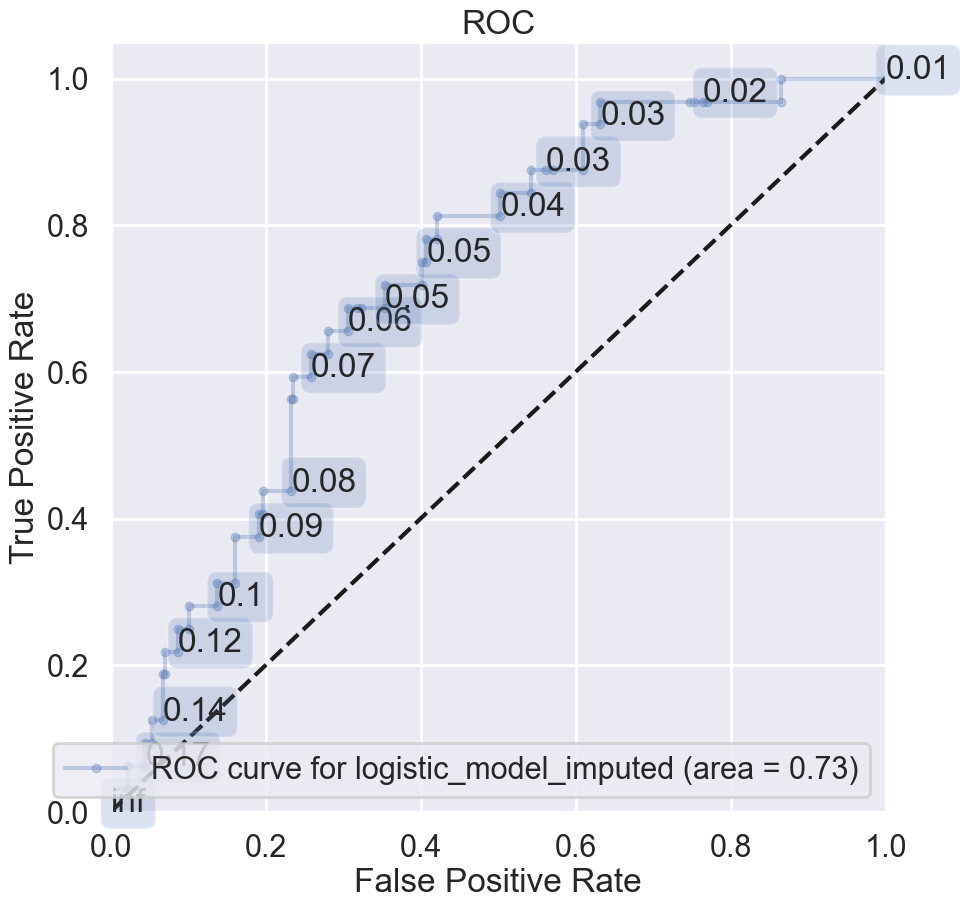

In [ ]:
# ROC curve using your provided function
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(10,10))
ax = make_roc("logistic_model_imputed", logit3, y_test_imp, X_test_imp, labe=4, skip=0)
plt.show()


In [42]:
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    return (probs[:, 1] > t).astype(int)

print("Test set confusion matrices:")
for thresh in [0.1, 0.2, 0.3, 0.4]:
    print(f"Threshold = {thresh}")
    print(confusion_matrix(y_test_imp, t_repredict(logit3, thresh, X_test_imp)))

print("\nTraining set confusion matrices:")
for thresh in [0.1, 0.2, 0.3]:
    print(f"Threshold = {thresh}")
    print(confusion_matrix(y_train_imp, t_repredict(logit3, thresh, X_train_imp)))

Test set confusion matrices:
Threshold = 0.1
[[307  49]
 [ 23   9]]
Threshold = 0.2
[[347   9]
 [ 30   2]]
Threshold = 0.3
[[356   0]
 [ 31   1]]
Threshold = 0.4
[[356   0]
 [ 32   0]]

Training set confusion matrices:
Threshold = 0.1
[[957 139]
 [ 39  28]]
Threshold = 0.2
[[1067   29]
 [  57   10]]
Threshold = 0.3
[[1091    5]
 [  66    1]]


So I tested 2 different ways of calculating the missing income. The only difference between the two versions is that I included poorhealth as a feature to predict the income. This could lead to data leakage tho, and from the results it also probably happened. When I did not include the poorhealth as a feature, teh AUC was 0.73, indicating no difference and no improvement from teh previous models. With poorhealth included in the prediction of income the final model had AUC 0.81, which is a slight improvement and the best AUC we got so far. 

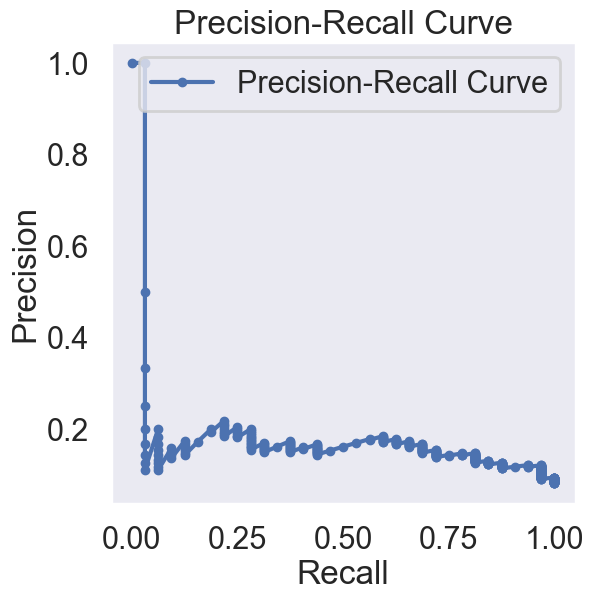

In [ ]:
precision, recall, _ = precision_recall_curve(y_test_imp, logit3.predict_proba(X_test_imp)[:, 1])
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

### Question 9 <a name="q9"></a>


Now comment on the performance of difference imputation methods and on the impact it has on the final model performance.


**Your answer goes here**
To impute the income using regression we tested two approaches: one that excluded the "poorhealth" variable from the imputation model, and one that included it. In the first approach, the final logistic regression model had an ROC AUC of 0.73, which means there is little to no difference between the mean and regression method. In the second approach, where "poorhealth" was used as a feature for income prediction, the ROC AUC rose to around 0.81. This would mean  that including "poorhealth" in the imputation seems beneficial, as it improves the predictive performance of the final model.

However, this improvement might be due to data leakage. Including "poorhealth" in the linear regression used to predict income, the predicted income values become partially dependent on "poorhealth". In other words, some information about the target is encoded into the feature that the final model then uses to predict "poorhealth". 

To avoid data leakage, we can simply exclude "poorhealth" from the features, even though it results in a lower ROC AUC (around 0.73).

## Part 3: Improving the model.

### Question 10 <a name="q10"></a>


Apply regularization (with cross-validation) to make sure not to overfit to the data and try also different models, like a Decision Tree or a Random Forest. Report on your results for which model handles inbalances in the best way.

For this question, you are also free (but not onbliged) to use techniques to address class imbalances (as we discussed in class) both on the data or model level. Recall that each method has advantages and disadvantages, so you will need to correctly interpret the results and assess the performance of any method you choose on the problem we explore here. Some examples can be found [here](https://imbalanced-learn.org/stable/index.html). 

In [33]:
# X_train_imp, X_test_imp, y_train_imp, y_test_imp      <--- using logistic regression for income
# X_train, X_test, y_train, y_test      <--- without income
# X_train_impute, X_test_impute, y_train_impute, y_test_impute    <--- using mean imputation for income

In [44]:
X_train, X_test, y_train, y_test = X_train_imp, X_test_imp, y_train_imp, y_test_imp


# 1) Logistic Regression with CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg_cv = LogisticRegressionCV(
    Cs=np.logspace(-3, 3, 1000),
    cv=cv,
    scoring='roc_auc',
    random_state=42,
    max_iter=1000,
    class_weight='balanced',  # helps with imbalance
    n_jobs=-1, # use all available CPU cores
)
logreg_cv.fit(X_train, y_train)

y_pred_lr = logreg_cv.predict(X_test)
y_prob_lr = logreg_cv.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_prob_lr)

print("=== Regularized Logistic Regression with CV ===")
print("Best C:", logreg_cv.C_[0])
print("Test Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC:", auc_lr)
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:\n", cm_lr)

=== Regularized Logistic Regression with CV ===
Best C: 0.0029817722900196734
Test Accuracy: 0.6726804123711341
ROC AUC: 0.7159410112359551
              precision    recall  f1-score   support

           0       0.95      0.68      0.79       356
           1       0.14      0.59      0.23        32

    accuracy                           0.67       388
   macro avg       0.55      0.64      0.51       388
weighted avg       0.88      0.67      0.75       388

Confusion Matrix:
 [[242 114]
 [ 13  19]]


Here we used LogisticRegressionCV with Cs=np.logspace(-3, 3, 1000) to search for the optimal Regularization parameter C. The best C is quite low indicating strong regularization is the best in our case. ROC AUC is around 0.72, which means the model has some discriminative power. From the report we can see that minority-class (label = 1) recall is ~0.59, meaning the model catches more than half of the positives, but the precision is low (0.14), so many predicted positives are actually negatives. This trade-off is expected in imbalanced settings: improving recall often hurts precision.

In [45]:
# 2) Decision Tree with GridSearch
tree_params = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [None, 'balanced']
}
dt = DecisionTreeClassifier(random_state=42)
tree_grid = GridSearchCV(dt, tree_params, cv=cv, scoring='roc_auc', n_jobs=-1)
tree_grid.fit(X_train, y_train)

best_tree = tree_grid.best_estimator_
y_pred_tree = best_tree.predict(X_test)
y_prob_tree = best_tree.predict_proba(X_test)[:, 1]
auc_tree = roc_auc_score(y_test, y_prob_tree)

print("\n=== Decision Tree ===")
print("Best Params:", tree_grid.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred_tree))
print("ROC AUC:", auc_tree)
print(classification_report(y_test, y_pred_tree))

cm_tree = confusion_matrix(y_test, y_pred_tree)
print("Confusion Matrix:\n", cm_tree)


=== Decision Tree ===
Best Params: {'class_weight': None, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 0.9123711340206185
ROC AUC: 0.723095154494382
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       356
           1       0.25      0.03      0.06        32

    accuracy                           0.91       388
   macro avg       0.58      0.51      0.50       388
weighted avg       0.86      0.91      0.88       388

Confusion Matrix:
 [[353   3]
 [ 31   1]]


Here we performed a GridSearchCV on hyperparameters such as max_depth, min_samples_split, min_samples_leaf, and class_weight to find teh optimal for our Decision Tree model. From the results we can see that a relatively shallow tree (max_depth=3, min_samples_split=2, min_samples_leaf=1, and interestingly class_weight=None) was chosen by the cross-validation to have the best AUC. 
This Decision Tree had accuracy ~0.91 on the test set, but that number is again misleadingly high due to the class imbalance. From the confusion matrix we see that the tree is mostly predicting negatives.
Final AUC is around 0.72, which is comparable to the logistic regression. From the classification report we observe that the tree’s recall for the minority class is extremely low (0.03), meaning it barely flags any positives.

In [ ]:
# 3) Random Forest

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',  # tries to account for class imbalance
    n_jobs=-1  # use all available CPU cores
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_prob_rf)

print("\n=== Random Forest ===")
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", auc_rf)
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm_rf)


=== Random Forest ===
Test Accuracy: 0.9072164948453608
ROC AUC: 0.725465238764045
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       356
           1       0.00      0.00      0.00        32

    accuracy                           0.91       388
   macro avg       0.46      0.49      0.48       388
weighted avg       0.84      0.91      0.87       388

Confusion Matrix:
 [[352   4]
 [ 32   0]]


A random forest is just using multiple decision trees, each trained on a bootstrapped sample of the data with some randomness in feature selection. The predictions are averaged, which should improve generalization compared to a single tree. That is why we expected better results to the singe Decision Tree model.
We set n_estimators=100 to build 100 trees and set class_weight='balanced' to help the model pay more attention to minority-class examples.
We did not perform a grid search for hyperparameter tuning here.
The results are agian simmilar with accuracy 0.91, which is again misleading as the model classifies nearly everything as negative.
The ROC AUC is 0.73, which very similar to the other models.
From the classification report and confusion matrix we can see the minority class (label = 1) gets 0% recall in this run, meaning the model missed all positives.


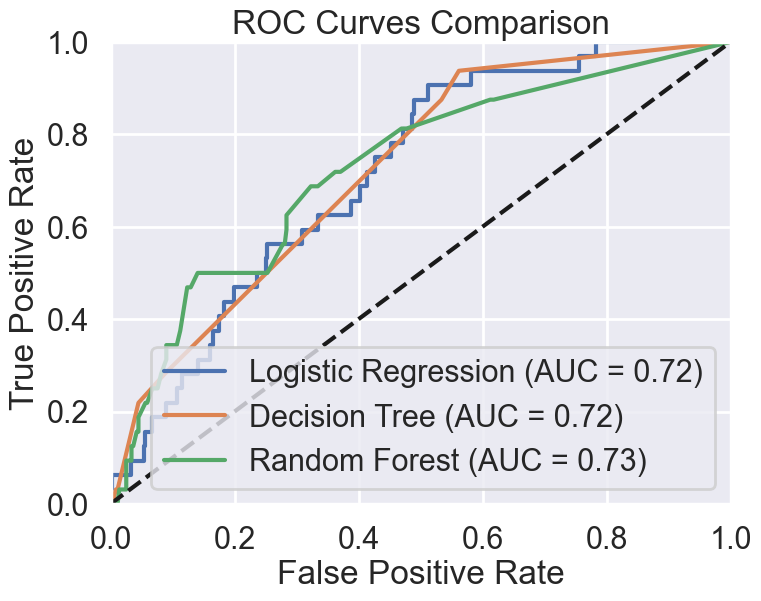

In [47]:
# --- Plot ROC Curves ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {auc_tree:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.show()


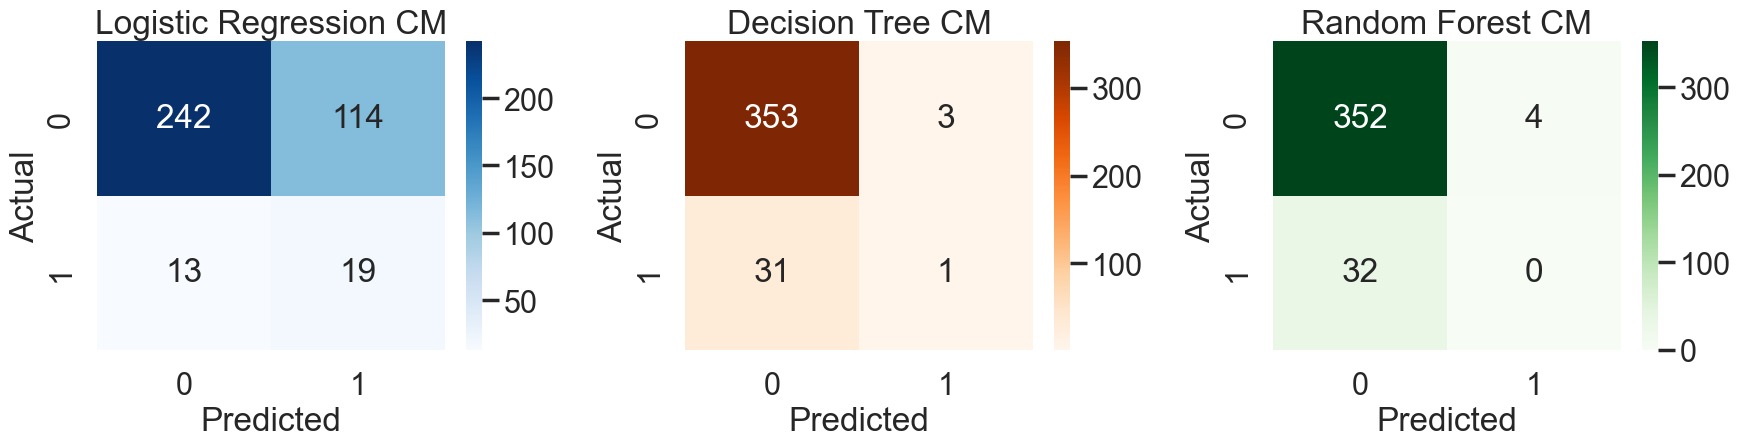

In [48]:
# --- Plot Confusion Matrices ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Logistic Regression CM")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("Decision Tree CM")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", ax=axes[2])
axes[2].set_title("Random Forest CM")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()

We see that for all models the ROC AUC is around 0.72-0.73 and from the results we can deduct the biggest problem is the class imbalance. To tackle this we try SMOTE to oversample the minority class, tune thresholds, and use cost-sensitive learning for Random Forest.   

In [ ]:
# Create the SMOTE object
smote = SMOTE(random_state=42)

# Fit SMOTE on the training set and resample
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original training set shape:", X_train.shape, "->", np.bincount(y_train))
print("SMOTE training set shape:", X_train_smote.shape, "->", np.bincount(y_train_smote))


Original training set shape: (1163, 12) -> [1096   67]
SMOTE training set shape: (2192, 12) -> [1096 1096]


In [ ]:
# Logistic Regression with CV on SMOTE data + Threshold Tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg_cv_sm = LogisticRegressionCV(
    Cs=np.logspace(-3, 3, 1000),
    cv=cv,
    scoring='roc_auc',
    random_state=42,
    max_iter=1000,
    class_weight=None, 
    n_jobs=-1,
)
logreg_cv_sm.fit(X_train_smote, y_train_smote)

y_pred_lr_sm = logreg_cv_sm.predict(X_test)
y_prob_lr_sm = logreg_cv_sm.predict_proba(X_test)[:, 1]
auc_lr_sm = roc_auc_score(y_test, y_prob_lr_sm)

print("=== Regularized Logistic Regression with CV (SMOTE) ===")
print("Best C:", logreg_cv_sm.C_[0])
print("Test Accuracy (Default Threshold):", accuracy_score(y_test, y_pred_lr_sm))
print("ROC AUC (Default Threshold):", auc_lr_sm)
print(classification_report(y_test, y_pred_lr_sm))
cm_lr_sm = confusion_matrix(y_test, y_pred_lr_sm)
print("Confusion Matrix (Default Threshold):\n", cm_lr_sm)

# Threshold tuning for Logistic Regression
best_thr_lr = 0.5
best_f1_lr = 0
thresholds = np.linspace(0, 1, 101)
for thr in thresholds:
    preds_thr = (y_prob_lr_sm >= thr).astype(int)
    f1 = f1_score(y_test, preds_thr, pos_label=1)
    if f1 > best_f1_lr:
        best_f1_lr = f1
        best_thr_lr = thr

print(f"\nBest Threshold for Logistic Regression: {best_thr_lr:.2f}, F1-score: {best_f1_lr:.3f}")
y_pred_lr_best = (y_prob_lr_sm >= best_thr_lr).astype(int)
print("Confusion Matrix (Best Threshold):\n", confusion_matrix(y_test, y_pred_lr_best))
print(classification_report(y_test, y_pred_lr_best))
print("\n")


=== Regularized Logistic Regression with CV (SMOTE) ===
Best C: 0.245691646298279
Test Accuracy (Default Threshold): 0.75
ROC AUC (Default Threshold): 0.6471207865168539
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       356
           1       0.15      0.44      0.22        32

    accuracy                           0.75       388
   macro avg       0.54      0.61      0.54       388
weighted avg       0.87      0.75      0.80       388

Confusion Matrix (Default Threshold):
 [[277  79]
 [ 18  14]]

Best Threshold for Logistic Regression: 0.43, F1-score: 0.252
Confusion Matrix (Best Threshold):
 [[256 100]
 [ 13  19]]
              precision    recall  f1-score   support

           0       0.95      0.72      0.82       356
           1       0.16      0.59      0.25        32

    accuracy                           0.71       388
   macro avg       0.56      0.66      0.54       388
weighted avg       0.89      0.71      0.77    

With SMOTE, the Logistic Regression model found a best Regularizacion C of approximately 0.246, which means moderate regularization (and this is lower than without SMOTE). At the default threshold of 0.5, the test accuracy increased to 75% compared to around 67% without SMOTE, however, the ROC AUC decreased from 0.716 (without SMOTE) to 0.647 with SMOTE. This drop might be because the oversampling causes the model to overfit on synthetic examples. The confusion matrix shows that many more negatives are being predicted (277 true negatives with 79 false positives), and the minority class has 18 false negatives versus 14 true positives. After searching for the optimal threshold, the best threshold was found to be 0.43 (instead of the default 0.5), which is just a slight shift. With this threshold, the confusion matrix changes — fewer negatives are predicted (256 TN, 100 FP) and minority performance slightly improves (13 FN, 19 TP). The F1-score for the minority class increased, even though overall accuracy might drop slightly. This is a typical trade-off when shifting the threshold to capture more positives.

In [ ]:
# Decision Tree with GridSearch on SMOTE data + Threshold Tuning 
tree_params = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [None, 'balanced']
}
dt_sm = DecisionTreeClassifier(random_state=42)
tree_grid_sm = GridSearchCV(dt_sm, tree_params, cv=cv, scoring='roc_auc', n_jobs=-1)
tree_grid_sm.fit(X_train_smote, y_train_smote)

best_tree_sm = tree_grid_sm.best_estimator_
y_pred_tree_sm = best_tree_sm.predict(X_test)
y_prob_tree_sm = best_tree_sm.predict_proba(X_test)[:, 1]
auc_tree_sm = roc_auc_score(y_test, y_prob_tree_sm)

print("=== Decision Tree (SMOTE + GridSearch) ===")
print("Best Params:", tree_grid_sm.best_params_)
print("Test Accuracy (Default Threshold):", accuracy_score(y_test, y_pred_tree_sm))
print("ROC AUC (Default Threshold):", auc_tree_sm)
print(classification_report(y_test, y_pred_tree_sm))
cm_tree_sm = confusion_matrix(y_test, y_pred_tree_sm)
print("Confusion Matrix (Default Threshold):\n", cm_tree_sm)

# Threshold tuning for Decision Tree
best_thr_tree = 0.5
best_f1_tree = 0
for thr in thresholds:
    preds_thr = (y_prob_tree_sm >= thr).astype(int)
    f1 = f1_score(y_test, preds_thr, pos_label=1)
    if f1 > best_f1_tree:
        best_f1_tree = f1
        best_thr_tree = thr

print(f"\nBest Threshold for Decision Tree: {best_thr_tree:.2f}, F1-score: {best_f1_tree:.3f}")
y_pred_tree_best = (y_prob_tree_sm >= best_thr_tree).astype(int)
print("Confusion Matrix (Best Threshold):\n", confusion_matrix(y_test, y_pred_tree_best))
print(classification_report(y_test, y_pred_tree_best))
print("\n")


=== Decision Tree (SMOTE + GridSearch) ===
Best Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 15}
Test Accuracy (Default Threshold): 0.8402061855670103
ROC AUC (Default Threshold): 0.6448384831460674
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       356
           1       0.21      0.34      0.26        32

    accuracy                           0.84       388
   macro avg       0.57      0.61      0.59       388
weighted avg       0.88      0.84      0.86       388

Confusion Matrix (Default Threshold):
 [[315  41]
 [ 21  11]]

Best Threshold for Decision Tree: 0.26, F1-score: 0.309
Confusion Matrix (Best Threshold):
 [[306  50]
 [ 17  15]]
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       356
           1       0.23      0.47      0.31        32

    accuracy                           0.83       388
   macro avg       0.59

The best decision tree model with SMOTE found by GridSearchCV had the parameters class_weight='balanced', no limit on maximum depth, min_samples_leaf=2, and min_samples_split=15. At default threshold, the test accuracy is around 84% and ROC AUC is 0.645. The confusion matrix shows moderate performance on the majority class (315 true negatives and 41 false negatives) and not very good performance on the minority class (21 false negatives and 11 true positives). After threshold tuning, the best threshold was reduced to 0.26, which lead to an improved F1-score for the minority class. The new confusion matrix at the best threshold shows a shift with 306 TN, 50 FP, 17 FN, and 15 TP. This shift shows the model becomes less conservative when labeling positives, which helps improve recall for the minority class at the expense of more false positives.

In [ ]:
# Random Forest with SMOTE + Cost Sensitive Learning + Threshold Tuning
rf_sm = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',  # cost sensitive setting
    n_jobs=-1
)
rf_sm.fit(X_train_smote, y_train_smote)
y_pred_rf_sm = rf_sm.predict(X_test)
y_prob_rf_sm = rf_sm.predict_proba(X_test)[:, 1]
auc_rf_sm = roc_auc_score(y_test, y_prob_rf_sm)

print("=== Random Forest (SMOTE) ===")
print("Test Accuracy (Default Threshold):", accuracy_score(y_test, y_pred_rf_sm))
print("ROC AUC (Default Threshold):", auc_rf_sm)
print(classification_report(y_test, y_pred_rf_sm))
cm_rf_sm = confusion_matrix(y_test, y_pred_rf_sm)
print("Confusion Matrix (Default Threshold):\n", cm_rf_sm)

# Threshold tuning for Random Forest
best_thr_rf = 0.5
best_f1_rf = 0
for thr in thresholds:
    preds_thr = (y_prob_rf_sm >= thr).astype(int)
    f1 = f1_score(y_test, preds_thr, pos_label=1)
    if f1 > best_f1_rf:
        best_f1_rf = f1
        best_thr_rf = thr

print(f"\nBest Threshold for Random Forest: {best_thr_rf:.2f}, F1-score: {best_f1_rf:.3f}")
y_pred_rf_best = (y_prob_rf_sm >= best_thr_rf).astype(int)
print("Confusion Matrix (Best Threshold):\n", confusion_matrix(y_test, y_pred_rf_best))
print(classification_report(y_test, y_pred_rf_best))

=== Random Forest (SMOTE) ===
Test Accuracy (Default Threshold): 0.8737113402061856
ROC AUC (Default Threshold): 0.8066625702247191
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       356
           1       0.27      0.31      0.29        32

    accuracy                           0.87       388
   macro avg       0.60      0.62      0.61       388
weighted avg       0.88      0.87      0.88       388

Confusion Matrix (Default Threshold):
 [[329  27]
 [ 22  10]]

Best Threshold for Random Forest: 0.35, F1-score: 0.372
Confusion Matrix (Best Threshold):
 [[318  38]
 [ 16  16]]
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       356
           1       0.30      0.50      0.37        32

    accuracy                           0.86       388
   macro avg       0.62      0.70      0.65       388
weighted avg       0.90      0.86      0.88       388



The Random Forest model, with 100 trees and using class_weight='balanced', achieved a default accuracy of about 87.4% and a notably higher ROC AUC of 0.807. The confusion matrix shows 329 TN and 27 FP for the majority class, and 22 FN versus 10 TP for the minority class. This shows that Random Forest after SMOTE is better at ranking positive cases than the other models, even though by default it may miss some minority cases. But after threshold tuning, the best threshold was found to be around 0.35. With this threshold, the confusion matrix shifts to 318 TN, 38 FP, 16 FN, and 16 TP. The F1-score for the minority class improved to about 0.37, which is the best among the three models.
The Random Forest benefits the most from SMOTE and cost-sensitive adjustments, as seen by the improved ROC AUC and better performance after threshold tuning.

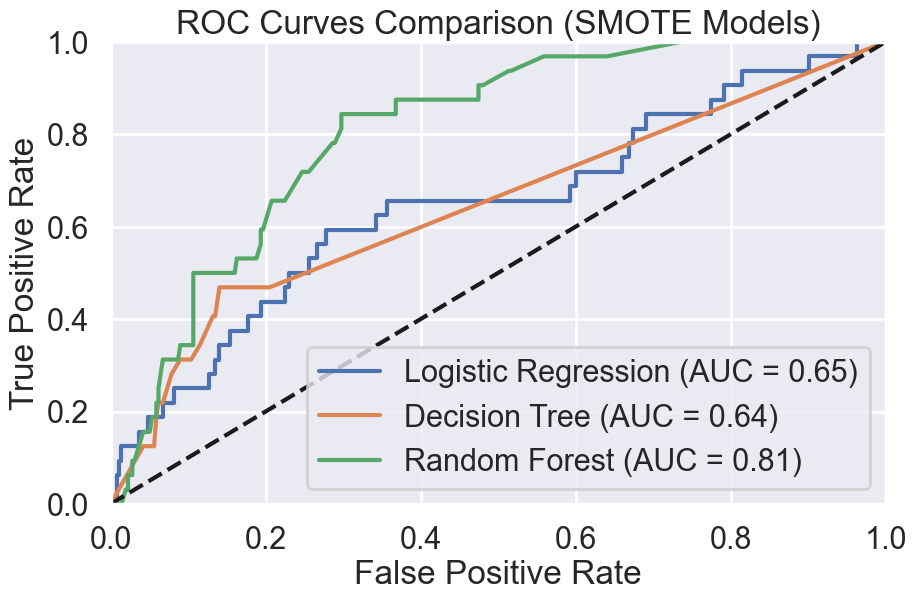

In [ ]:
# ROC for all three models (SMOTE)
plt.figure(figsize=(10,6))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr_sm)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc(fpr_lr, tpr_lr):.2f})')

fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree_sm)
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {auc(fpr_tree, tpr_tree):.2f})')

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf_sm)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison (SMOTE Models)')
plt.legend(loc='lower right')
plt.show()


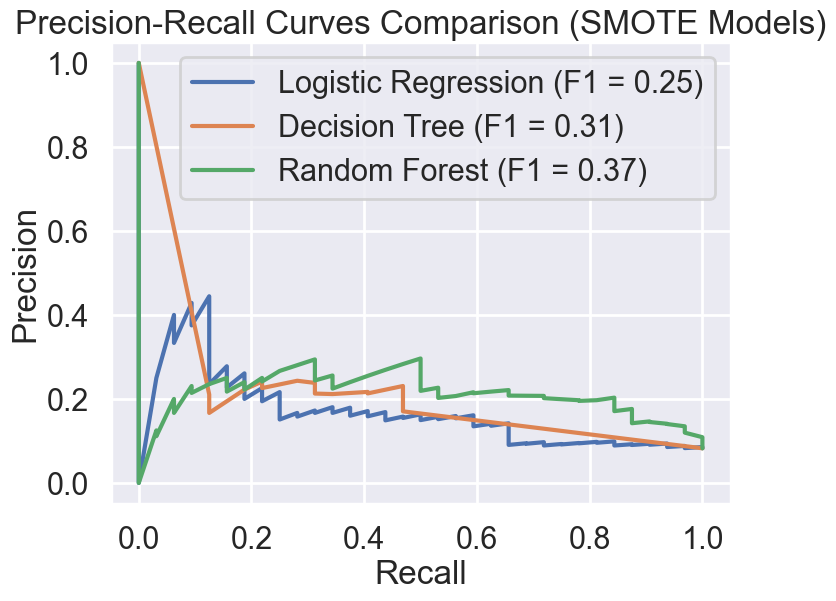

In [ ]:
# Precision-Recall for all three models
plt.figure(figsize=(8,6))

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr_sm)
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (F1 = {best_f1_lr:.2f})')

precision_tree, recall_tree, _ = precision_recall_curve(y_test, y_prob_tree_sm)
plt.plot(recall_tree, precision_tree, label=f'Decision Tree (F1 = {best_f1_tree:.2f})')

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf_sm)
plt.plot(recall_rf, precision_rf, label=f'Random Forest (F1 = {best_f1_rf:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves Comparison (SMOTE Models)')
plt.legend(loc='upper right')
plt.show()


The final results show that SMOTE significantly alters the training distribution, enabling the models (especially Random Forest) to improve recall and F1 for the minority class. Moreover, cost-sensitive learning further adjusts the model’s focus on minority cases and threshold tuning helps achieve the best balance between precision and recall, although it does not affect the ROC AUC.
Overall, Logistic Regression shows moderate performance after improvements but has lower ROC AUC. The Decision Tree is still quite sensitive to threshold adjustments. The Random Forest shows the best overall ROC AUC and F1 improvement after SMOTE and threshold tuning, suggesting it handles imbalance most effectively in this case.